## Set up Google Colab environment

In [1]:
### Set colaboratory True to run in Google Colaboratory. 
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    ## Specify a directory in Google Drive
    dir = '/content/drive/My Drive/Colab Notebooks/Keras_Dense_Only_MNIST'
    os.chdir(dir)
    #os.getcwd()
    #os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
if colab:
    ## Check the uptime. (Google Colab reboots every 12 hours)
    !cat /proc/uptime | awk '{print "Uptime is " $1 /60 /60 " hours (" $1 " sec)"}'
    ## Check the GPU info
    !nvidia-smi
    ## Check the Python version
    !python --version

Uptime is 5.48378 hours (19741.60 sec)
Mon Jan 28 09:54:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    69W / 149W |   2198MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                     

## Import modules

In [3]:
import os
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

tf.__version__

'1.12.0'

## Train model

In [0]:
import glob
class ModelFileProcessing():
    def __init__(self, model_file_prefix = 'model_epoch', model_file_suffix = '.hdf5', verbose = 2):
        self.model_file_prefix = model_file_prefix
        self.model_file_suffix = model_file_suffix
        self.verbose = verbose
        model_file_path = model_file_prefix + '{epoch:06d}' + model_file_suffix
        self.model_file_path = model_file_path
        self.update()
    def update(self):
        model_file_prefix = self.model_file_prefix
        model_file_suffix = self.model_file_suffix
        model_file_list = glob.glob(model_file_prefix + '*' + model_file_suffix)
        model_file_list.sort()
        if self.verbose >= 2:
            print('Model files found: ', model_file_list)
        self.model_file_list = model_file_list
        model_file_exists = len(model_file_list) >= 1
        self.model_file_exists = model_file_exists

        latest_model_file = model_file_list[-1] if model_file_exists else None
        self.latest_model_file = latest_model_file

        latest_epoch = int(latest_model_file[len(model_file_prefix):-len(model_file_suffix)]) \
            if model_file_exists else 0
        self.latest_epoch = latest_epoch

        multiple_model_files_exist = len(model_file_list) >= 2
        self.multiple_model_files_exist = multiple_model_files_exist
    def clean_up_old(self):
        self.update()
        ## Delete all model files excpet the latest to save space
        if self.multiple_model_files_exist:
            for f in self.model_file_list[:-1]:
                os.remove(f)  
    def clean_up_all(self):
        self.update()
        ## Delete all model files if they exist.
        if self.model_file_exists:
            for f in self.model_file_list:
                os.remove(f)   

class LogFileProcessing():
    def __init__(self, log_file_path = 'training_log.csv', verbose = 2):
        self.log_file_path = log_file_path
        self.verbose = verbose
        self.update()
    def update(self):
        log_file_path = self.log_file_path
        log_file_list = glob.glob(log_file_path)
        log_file_list.sort()
        self.log_file_list = log_file_list
        if self.verbose >= 2:
            print('Log file found:', log_file_list)
        log_file_exists = len(log_file_list) >= 1
        self.log_file_exists = log_file_exists
    def truncate(self):
        log_file_path = self.log_file_path
        self.update()
        ## Remove rows after the epoch of the latest saved model 
        ## (needed because save_best_only option of checkpoint is set to True.)
        with open(log_file_path, 'r') as f:
            lines = f.readlines()
        if self.verbose >= 3:
            print('Log file contents read:', lines)
        lines_truncated = lines[:(mfp.latest_epoch+1)]
        with open(log_file_path, 'w') as f:
            f.writelines(lines_truncated)
        if self.verbose >= 3:
            print('New log file contents', lines_truncated)
    def clean_up(self):
        self.update()
        if self.log_file_exists:
            for f in self.log_file_list:
                os.remove(f) 
                
import time          
class CompTime(keras.callbacks.Callback):
    def __init__(self, log_file_path = 'training_log.csv', verbose = 2):
        self.log_file_path = log_file_path
        self.verbose = verbose
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        comp_time = time.time() - self.epoch_time_start
        logs['Comp_time'] = comp_time
        print('Computation time: {} sec'.format(comp_time))
        cum_comp_time_prev = 0.0
        try:
            log_df = pd.read_csv(self.log_file_path)
            if log_df.shape[0] >= 1:
                cum_comp_time_prev = float(log_df.iloc[-1]['Cum_comp_time'])
        except:
            print('Failed to read the previous cumulative computation time, but continue training.')
        logs['Cum_comp_time'] = cum_comp_time_prev + comp_time
        
class OldModelFileCleanup(keras.callbacks.Callback):
    def __init__(self, mfp):
        self.mfp = mfp
    def on_epoch_end(self, batch, logs={}):     
        self.mfp.clean_up_old()
           
def setup_model_and_callbacks(create_model, input_shape, resume_if_possible = True):
    mfp = ModelFileProcessing()   
    lfp = LogFileProcessing()
    resume_flag = resume_if_possible and mfp.model_file_exists and lfp.log_file_exists

    if resume_flag:
        initial_epoch = mfp.latest_epoch
        mfp.clean_up_old() ## To do: should be ok to delete this
        lfp.truncate() ## Truncate the log file
        ## Load the saved model
        model = keras.models.load_model(mfp.latest_model_file)
        print('Use {} to resume fitting.'.format(mfp.latest_model_file))

    if not resume_flag:
        initial_epoch = 0
        ## Delete all model files and the log file if they exist.
        mfp.clean_up_all()
        lfp.clean_up()
        ## Create a basic model instance
        model = create_model(input_shape)
        print('Model created.')

    ## Create checkpoint callback
    check_point_ = tf.keras.callbacks.ModelCheckpoint(filepath = mfp.model_file_path, 
        monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'auto', 
        save_weights_only = False, period = 1)
    
    ## Create old model file cleanup callback
    old_model_file_cleanup_ = OldModelFileCleanup(mfp)
    
    ## Create computation time callback
    comp_time_ = CompTime()

    ## Create CSV logger callback
    csv_logger_ = tf.keras.callbacks.CSVLogger(filename = lfp.log_file_path, separator=',',
                                               append = resume_flag)

    ## Create early stopping callback
    early_stopping_ = tf.keras.callbacks.EarlyStopping(monitor='val_acc', 
        min_delta=0, patience=5, verbose=1, mode='auto', baseline=None)

    callbacks = [check_point_, old_model_file_cleanup_, comp_time_, csv_logger_, early_stopping_]

    return model, callbacks, initial_epoch

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adagrad, RMSprop, Adam

batch_size_list = []
batch_size_list.append(64)

optimizer_dict = {}
#optimizer_dict['SGD'] = SGD()
#optimizer_dict['SGD_momentum_0.5'] = SGD(momentum = 0.5)
#optimizer_dict['SGD_momentum_0.9'] = SGD(momentum = 0.9)
#optimizer_dict['SGD_momentum_0.99'] = SGD(momentum = 0.99)         
#optimizer_dict['Adagrad'] = Adagrad()
#optimizer_dict['RMSprop'] = RMSprop()
optimizer_dict['Adam'] = Adam()

activation_list = []
activation_list.append('relu')
#activation_list.append('sigmoid')
#activation_list.append('elu')

dropout_rate_list = []
#dropout_rate_list.append(0.0)
dropout_rate_list.append(0.2)
#dropout_rate_list.append(0.5)
#dropout_rate_list.append(0.8)

d = {}
model_param_dict_list = []
i = 0
for batch_size in batch_size_list:
    for optimizer, _ in optimizer_dict.items():
        for activation in activation_list:
            for dropout_rate in dropout_rate_list:
                d = {}
                d['_Model_id'] = '{:06d}'.format(i)
                d['Batch_size'] = batch_size
                d['Optimizer'] = optimizer
                d['Acivation'] = activation
                d['Dropout_rate'] = dropout_rate
                i += 1
                print(d)
                model_param_dict_list.append(d)
            

{'_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Dropout_rate': 0.2}


Using TensorFlow backend.


In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print('x_train: ', x_train.shape)
print('y_train', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test', y_test.shape)


input_shape = x_train.shape[1:]
print('input_shape: ', input_shape )

num_classes = 10

x_train = x_train / 255.0
x_test = x_test / 255.0

#y_train = keras.utils.to_categorical(y_train, num_classes = num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes = num_classes)

## Reduce samples size to speed up 

n = 1000

y_train = y_train[:n]
y_test = y_test[:n]

x_train = x_train[:n]
x_test = x_test[:n]

print('### data after processing')
print('x_train: ', x_train.shape)
print('y_train', y_train.shape)
print('x_test: ', x_test.shape)
print('y_test', y_test.shape)


x_train:  (60000, 28, 28)
y_train (60000,)
x_test:  (10000, 28, 28)
y_test (10000,)
input_shape:  (28, 28)
### data after processing
x_train:  (1000, 28, 28)
y_train (1000,)
x_test:  (1000, 28, 28)
y_test (1000,)


In [9]:
## Set resume_if_possible = True to resume using a model file if available.
## Set resume_if_possible = False to force fitting from scratch.
resume_if_possible = True
#resume_if_possible = False
epochs = 100


for model_param_dict in model_param_dict_list:
    print(model_param_dict)
    for key,val in model_param_dict.items():
        exec(key + '=val')

    def create_model(input_shape):
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(512, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(10, activation='softmax'))

        model.compile(optimizer = optimizer_dict[optimizer], 
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
        return model
    
    model, callbacks, initial_epoch = \
    setup_model_and_callbacks(create_model, input_shape, resume_if_possible = resume_if_possible)

    model.summary()

    ## Fit 
    model.fit(x_train, y_train, validation_data = (x_test, y_test), shuffle = True,
              batch_size = batch_size, epochs = epochs, callbacks = callbacks, initial_epoch = initial_epoch)

{'_Model_id': '000000', 'Batch_size': 64, 'Optimizer': 'Adam', 'Acivation': 'relu', 'Dropout_rate': 0.2}
Model files found:  ['model_epoch000007.hdf5']
Log file found: ['training_log.csv']
Model files found:  ['model_epoch000007.hdf5']
Log file found: ['training_log.csv']
Use model_epoch000007.hdf5 to resume fitting.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_______________

Model files found:  ['model_epoch000009.hdf5']
Final Model:  model_epoch000009.hdf5  
  val_acc:  0.871000
  val_loss: 0.404079
Log file found: ['training_log.csv']


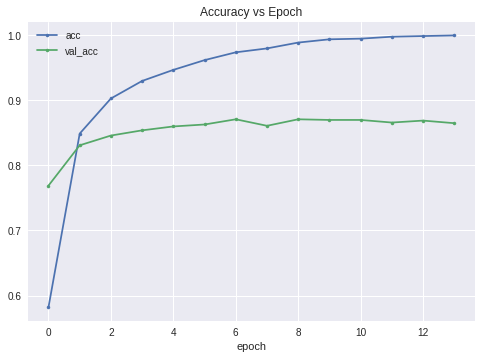

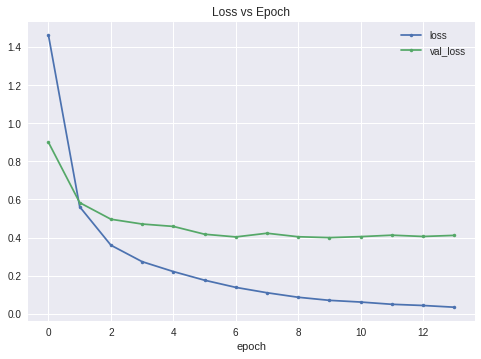

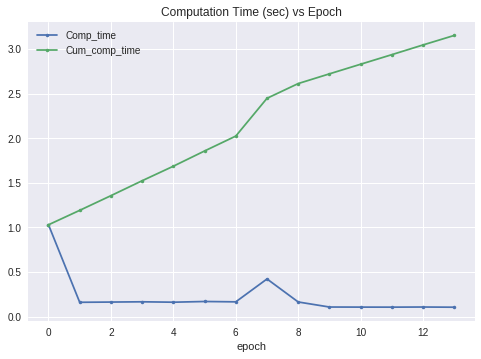

,epoch,Comp_time,Cum_comp_time,acc,loss,val_acc,val_loss
0,0,1.030137,1.030137,0.582,1.461231,0.769,0.899532
1,1,0.161748,1.191885,0.849,0.561450,0.831,0.583043
2,2,0.164372,1.356256,0.903,0.359694,0.846,0.496123
3,3,0.167309,1.523566,0.930,0.273300,0.854,0.470933
4,4,0.162757,1.686323,0.947,0.221405,0.860,0.458392
5,5,0.170705,1.857028,0.962,0.175937,0.863,0.417373
6,6,0.166816,2.023844,0.974,0.138330,0.871,0.403255
7,7,0.423223,2.447067,0.980,0.110128,0.861,0.422542
8,8,0.165164,2.612230,0.989,0.086429,0.871,0.404079
9,9,0.108737,2.720967,0.994,0.070249,0.870,0.399621


In [10]:
## Show final model performance metrics
mfp = ModelFileProcessing()
model = keras.models.load_model(mfp.latest_model_file)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)
print("Final Model:  {}  \n  val_acc:  {:8.6f}\n  val_loss: {:8.6f}".format(mfp.latest_model_file, val_acc, val_loss))

## Plot the results
lfp = LogFileProcessing()
if lfp.log_file_exists:
    log_df = pd.read_csv(lfp.log_file_path)
    log_df.set_index('epoch')[['acc', 'val_acc']].plot(style='.-', title='Accuracy vs Epoch')
    plt.show()
    log_df.set_index('epoch')[['loss', 'val_loss']].plot(style='.-', title='Loss vs Epoch')
    plt.show()
    log_df.set_index('epoch')[['Comp_time', 'Cum_comp_time']].plot(style='.-', title='Computation Time (sec) vs Epoch')
    plt.show()
    # pd.options.display.max_rows = 8
    display(log_df)

References:


https://keras.io/callbacks/

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

https://keras.io/getting-started/sequential-model-guide/